In [600]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler

from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


# Set random seed
seed = 42

In [601]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_tmbd_cleaned.csv', sep='|')


In [602]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 8784 non-null   int64  
 1   budget                8784 non-null   int64  
 2   genres                8780 non-null   object 
 3   original_language     8784 non-null   object 
 4   overview              8763 non-null   object 
 5   popularity            8784 non-null   float64
 6   production_companies  8618 non-null   object 
 7   production_countries  8737 non-null   object 
 8   revenue               8784 non-null   int64  
 9   runtime               8784 non-null   float64
 10  spoken_languages      8768 non-null   object 
 11  status                8784 non-null   object 
 12  tagline               6912 non-null   object 
 13  title                 8784 non-null   object 
 14  video                 8784 non-null   int64  
 15  vote_average         

# Scoring prediction

In [603]:
# Encode categorical variables
desired_order = ['bad', 'mediocre', 'good', 'great']
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(desired_order)
df['category'] = label_encoder.transform(df['category'])

In [604]:
X = df.drop(columns=['vote_average', 'category'])
Y = df['category']
print(df)


      adult     budget                                          genres  \
0         0  200000000       Adventure,Action,Thriller,Science Fiction   
1         0  130000000                Science Fiction,Action,Adventure   
2         0  165000000                Action,Adventure,Science Fiction   
3         0  120000000                Action,Adventure,Science Fiction   
4         0   78000000   Fantasy,Action,Crime,Science Fiction,Thriller   
...     ...        ...                                             ...   
8779      0          0  Mystery,Animation,Comedy,Family,Action,Fantasy   
8780      0          0                                     Documentary   
8781      0          0                                    Comedy,Crime   
8782      0          0                                    Action,Crime   
8783      0          0                                    Drama,Comedy   

     original_language                                           overview  \
0                   en  For centur

In [605]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  7027
Test set size:  1757


# Feature encoding

In [606]:
from sklearn.pipeline import FunctionTransformer
from sklearn.preprocessing import KBinsDiscretizer

# Drop text and list-based columns with too many unique values
X = X.drop(columns=['genres', 'overview', 'production_companies', 'spoken_languages', 'tagline', 'title', 'cast', 'directors'])

# Numerical features to discretize
numerical_features_to_discretize = ['budget', 'revenue', 'popularity', 'vote_count', 'runtime', 'release_year']

# Other numerical features (not being discretized)
other_numerical_features = ['release_month', 'release_day']

# Categorical features
categorical_features = ['original_language', 'status']

# Boolean features
boolean_features = ['adult', 'video']

# 1. Binning transformer for numerical features with high unique values
binning_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('discretizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile'))
])

# 2. Numerical transformer: Impute missing values and standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 3. Categorical transformer: Impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 4. Boolean transformer: Ensure 0/1 values
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('bin_num', binning_transformer, numerical_features_to_discretize),
        ('num', numeric_transformer, other_numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', boolean_transformer, boolean_features)
    ]
)

# Transparent Models

## Decision Tree

### C4.5 Algorithm

Functions needed to help calculate the Information Gain Ratio to be used with the tree. 


In [607]:
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    entropy_value = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) 
                            for i in range(len(elements)) if counts[i] > 0])
    return entropy_value

In [608]:
# 'category' has 4 possible values, so Entropy can range from 0 (perfectly pure, all values in one class) to 2 (all classes represented equally in the same number each)
e = entropy(df['category'])
elements, counts = np.unique(df['category'], return_counts=True)
print(e)
print(elements)
print(counts)

2.0
[0 1 2 3]
[2196 2196 2196 2196]


In [609]:
#Information Gain -> the expected reduction in entropy (more proximate to 0 = more pure = reached decision) caused by partitioning the dataset according to split_attribute_name
#                 -> the amount of information gained by spliting the data using split_attribute_name
#                 -> higher values are better
def info_gain(data, split_attribute_name, target_name='category'):
    total_entropy = entropy(data[target_name])
    values, counts = np.unique(data[split_attribute_name].astype(str), return_counts=True)
    
    # Weighted entropy calculation
    weighted_entropy = np.sum([
        (counts[i]/np.sum(counts)) * entropy(data[data[split_attribute_name].astype(str) == values[i]][target_name])
        for i in range(len(values)) if counts[i] > 0
    ])
    
    return total_entropy - weighted_entropy

In [610]:
#igainex1 = info_gain(df, 'budget')
#print(igainex1)

#igainex2 = info_gain(df, 'popularity')
#print(igainex2)

#igainex3 = info_gain(df, 'spoken_languages')
#print(igainex3)

In [611]:
#Information Gain Ratio  ->  ratio of information gain to the intrinsic information
#                        -> reduce a bias towards multi-valued attributes by taking the number and size of branches into account when choosing an attribute, biases the decision tree against considering attributes with a large number of distinct values (ex: ID would lead to maximum purity)
#                        -> higher values are better
def info_gain_ratio(data, split_attribute_name, target_name='category'):
    information_gain = info_gain(data, split_attribute_name, target_name)
    values, counts = np.unique(data[split_attribute_name].astype(str), return_counts=True)
    split_information = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) 
                                 for i in range(len(values)) if counts[i] > 0])
    return information_gain / split_information if split_information != 0 else 0

In [612]:
print(df.columns)

Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'directors', 'release_year',
       'release_month', 'release_day', 'category'],
      dtype='object')


In [613]:
#igrex1 = info_gain_ratio(df, 'budget')
#print(igrex1)

#igrex2 = info_gain_ratio(df, 'popularity')
#print(igrex2)

#igrex3 = info_gain_ratio(df, 'spoken_languages')
#print(igrex3)


In [614]:
# Count unique values in each column using nunique()
n = df.nunique()

print("Number of unique values in each column:\n", n)

Number of unique values in each column:
 adult                      1
budget                   697
genres                  1839
original_language         38
overview                8759
popularity              7434
production_companies    7316
production_countries     787
revenue                 5150
runtime                  164
spoken_languages         858
status                     1
tagline                 6870
title                   8534
video                      2
vote_average              17
vote_count              2902
cast                    8776
directors               4194
release_year             103
release_month             12
release_day               31
category                   4
dtype: int64


In [615]:
igrex1 = info_gain_ratio(df, 'cast')
print(igrex1)

igrex2 = info_gain(df, 'cast')
print(igrex2)

igrex1 = info_gain_ratio(df, 'video')
print(igrex1)

igrex2 = info_gain(df, 'video')
print(igrex2)

0.15266723343832633
1.9997723132969034
0.034721962625682855
0.0002836078058925384


In [616]:
# C4.5 Recursive Algorithm to build the Decision Tree
def c45_tree(data, original_data, features, target_name='category', parent_node_class=None, depth=0):
    print(f"Building tree at depth {depth}, dataset size: {len(data)}")
    
    # Base case 1: If all target values are the same, return that class
    if len(np.unique(data[target_name])) <= 1:
        print(f"Pure node reached with class: {np.unique(data[target_name])[0]}")
        return np.unique(data[target_name])[0]
    
     # Base case 2: If dataset is empty, return the class of the parent node
    if len(data) == 0:
        print(f"Empty dataset at depth {depth}, returning parent class: {parent_node_class}")
        return parent_node_class
    
    # Base case 3: If no more features to split on, return the majority class of the current node
    if len(features) == 0:
        print(f"No features left at depth {depth}, returning majority class: {parent_node_class}")
        return parent_node_class
    
    # Set the current node’s class to the majority class in this subset of data
    current_majority_class = data[target_name].mode()[0]

     # If parent_node_class was None, initialize it with the majority class of the entire data
    if parent_node_class is None:
        parent_node_class = current_majority_class
    
    # Calculate gain ratios for all features and select the feature with the highest gain ratio
    gain_ratios = [info_gain_ratio(data, feature, target_name) for feature in features]
    print(f"Gain Ratios at depth {depth}: {dict(zip(features, gain_ratios))}")
    
    best_feature_index = np.argmax(gain_ratios)
    best_feature = features[best_feature_index]
    
     # If the best gain ratio is 0 (no information gain), return the majority class
    if gain_ratios[best_feature_index] == 0:
        print(f"No gain from any feature at depth {depth}, returning majority class: {current_majority_class}")
        return current_majority_class

    tree = {best_feature: {}}

    # For each value of the best feature, split the data and recursively build the subtree
    for value in np.unique(data[best_feature].astype(str)):
        print(f"Splitting on {best_feature} = {value} at depth {depth}")
        sub_data = data[data[best_feature].astype(str) == value]

         # Recursively build the subtree with updated features list (excluding the best feature)
        subtree = c45_tree(
            sub_data, original_data, 
            [f for f in features if f != best_feature], 
            target_name, current_majority_class, depth + 1
        )
        tree[best_feature][value] = subtree
    print(f"Subtree at depth {depth} for feature {best_feature}: {tree}")

    

    return tree


In [617]:
# Apply the preprocessing to X_train and X_test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("X_train_processed shape:", X_train_processed.shape)

X_train_processed shape: (7027, 47)


C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [618]:
# Dynamically generate the feature names
preprocessed_feature_names = []

# For binned numerical features
preprocessed_feature_names.extend(numerical_features_to_discretize)

# For other numerical features
preprocessed_feature_names.extend(other_numerical_features)

# For categorical features (get names from OneHotEncoder)
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features).tolist()
preprocessed_feature_names.extend(cat_feature_names)

# For boolean features
preprocessed_feature_names.extend(boolean_features)

# Check the lengths to ensure consistency
print("Expected number of feature names:", len(preprocessed_feature_names))
print("X_train_processed shape:", X_train_processed.shape)

Expected number of feature names: 47
X_train_processed shape: (7027, 47)


In [619]:
print("X_train_processed shape before DataFrame conversion:", X_test_processed.shape)

# Confirm the lengths
print("Expected number of feature names:", len(preprocessed_feature_names))

# Convert the sparse matrices to dense arrays
X_train_processed_dense = X_train_processed.toarray()
X_test_processed_dense = X_test_processed.toarray()

X_train_processed_df = pd.DataFrame(X_train_processed_dense, columns=preprocessed_feature_names, index=X_train.index)
X_test_processed_df = pd.DataFrame(X_test_processed_dense, columns=preprocessed_feature_names, index=X_test.index)

print("X_train_processed_df shape:", X_train_processed_df.shape)
print("X_test_processed_df shape:", X_test_processed_df.shape)

X_train_processed shape before DataFrame conversion: (1757, 47)
Expected number of feature names: 47
X_train_processed_df shape: (7027, 47)
X_test_processed_df shape: (1757, 47)


In [620]:

# Print the results
print("X_train_processed columns:", X_train_processed_df.columns)
print("X_test_processed columns:", X_test_processed_df.columns)


X_train_processed columns: Index(['budget', 'revenue', 'popularity', 'vote_count', 'runtime',
       'release_year', 'release_month', 'release_day', 'original_language_ar',
       'original_language_bn', 'original_language_bs', 'original_language_cn',
       'original_language_cs', 'original_language_da', 'original_language_de',
       'original_language_el', 'original_language_en', 'original_language_es',
       'original_language_et', 'original_language_fa', 'original_language_fi',
       'original_language_fr', 'original_language_he', 'original_language_hi',
       'original_language_hu', 'original_language_id', 'original_language_it',
       'original_language_ja', 'original_language_ko', 'original_language_la',
       'original_language_nl', 'original_language_no', 'original_language_pl',
       'original_language_pt', 'original_language_ro', 'original_language_ru',
       'original_language_sh', 'original_language_sr', 'original_language_sv',
       'original_language_te', 'origi

In [621]:
unique_counts = X_train_processed_df.nunique()
print(unique_counts)


budget                   7
revenue                  7
popularity              10
vote_count              10
runtime                 10
release_year            10
release_month           12
release_day             31
original_language_ar     2
original_language_bn     2
original_language_bs     2
original_language_cn     2
original_language_cs     2
original_language_da     2
original_language_de     2
original_language_el     2
original_language_en     2
original_language_es     2
original_language_et     2
original_language_fa     2
original_language_fi     2
original_language_fr     2
original_language_he     2
original_language_hi     2
original_language_hu     2
original_language_id     2
original_language_it     2
original_language_ja     2
original_language_ko     2
original_language_la     2
original_language_nl     2
original_language_no     2
original_language_pl     2
original_language_pt     2
original_language_ro     2
original_language_ru     2
original_language_sh     2
o

In [622]:
print(pd.concat([X_train_processed_df, Y_train], axis=1).columns)

Index(['budget', 'revenue', 'popularity', 'vote_count', 'runtime',
       'release_year', 'release_month', 'release_day', 'original_language_ar',
       'original_language_bn', 'original_language_bs', 'original_language_cn',
       'original_language_cs', 'original_language_da', 'original_language_de',
       'original_language_el', 'original_language_en', 'original_language_es',
       'original_language_et', 'original_language_fa', 'original_language_fi',
       'original_language_fr', 'original_language_he', 'original_language_hi',
       'original_language_hu', 'original_language_id', 'original_language_it',
       'original_language_ja', 'original_language_ko', 'original_language_la',
       'original_language_nl', 'original_language_no', 'original_language_pl',
       'original_language_pt', 'original_language_ro', 'original_language_ru',
       'original_language_sh', 'original_language_sr', 'original_language_sv',
       'original_language_te', 'original_language_th', 'original

In [623]:
c45tree = c45_tree(
    pd.concat([X_train_processed_df, Y_train], axis=1),
    pd.concat([X_train_processed_df, Y_train], axis=1),
    X_train_processed_df.columns  
)


print(c45tree)

Building tree at depth 0, dataset size: 7027
Gain Ratios at depth 0: {'budget': 0.0544003069048478, 'revenue': 0.075083916996401, 'popularity': 0.06022524350790091, 'vote_count': 0.18566480750591483, 'runtime': 0.05949952881650796, 'release_year': 0.02993276918291375, 'release_month': 0.0036726589108952877, 'release_day': 0.002574280986217505, 'original_language_ar': 0.15006766653591905, 'original_language_bn': 0.13949291442252668, 'original_language_bs': 0.13949291442252668, 'original_language_cn': 0.04851601251069129, 'original_language_cs': 0.15703998246223963, 'original_language_da': 0.10863729514948511, 'original_language_de': 0.05412579261080131, 'original_language_el': 0.07558046969438069, 'original_language_en': 0.08711712194597404, 'original_language_es': 0.03276825440705037, 'original_language_et': 0.15006766653591905, 'original_language_fa': 0.11514338067532198, 'original_language_fi': 0.13949291442252668, 'original_language_fr': 0.011815651419380745, 'original_language_he':

In [624]:
def tree_predict(tree, sample, parent_node_class=None):
    # If the current tree node is a leaf, return the class
    if not isinstance(tree, dict):
        return tree

    # The current feature to split on
    feature = next(iter(tree))

    # Get the feature value from the sample
    feature_value = str(sample.get(feature, None))

    # Find the subtree that matches the feature value
    subtree = tree[feature].get(feature_value, None)

    # If no subtree exists, return the majority class of the parent node
    if subtree is None:
        return parent_node_class

    # Recursively predict using the subtree
    return tree_predict(subtree, sample, parent_node_class)


In [625]:
print(X_test_processed_df.columns) 

Index(['budget', 'revenue', 'popularity', 'vote_count', 'runtime',
       'release_year', 'release_month', 'release_day', 'original_language_ar',
       'original_language_bn', 'original_language_bs', 'original_language_cn',
       'original_language_cs', 'original_language_da', 'original_language_de',
       'original_language_el', 'original_language_en', 'original_language_es',
       'original_language_et', 'original_language_fa', 'original_language_fi',
       'original_language_fr', 'original_language_he', 'original_language_hi',
       'original_language_hu', 'original_language_id', 'original_language_it',
       'original_language_ja', 'original_language_ko', 'original_language_la',
       'original_language_nl', 'original_language_no', 'original_language_pl',
       'original_language_pt', 'original_language_ro', 'original_language_ru',
       'original_language_sh', 'original_language_sr', 'original_language_sv',
       'original_language_te', 'original_language_th', 'original

In [626]:

parent_class = Y_train.mode()[0]
Y_pred = [tree_predict(c45tree, sample, parent_class) for _, sample in X_test_processed_df.iterrows()]



print("Majority class (fallback):", parent_class)
print("Predictions:", Y_pred)


Majority class (fallback): 3
Predictions: [2, 0, 3, 2, 3, 2, 2, 1, 1, 3, 1, 3, 3, 0, 3, 2, 0, 0, 3, 0, 2, 0, 2, 1, 3, 1, 2, 0, 3, 2, 2, 0, 3, 3, 2, 2, 1, 3, 3, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 0, 1, 0, 3, 0, 0, 0, 2, 2, 3, 3, 3, 3, 0, 0, 0, 3, 1, 3, 3, 3, 2, 3, 2, 3, 0, 2, 3, 0, 1, 1, 3, 3, 3, 0, 2, 3, 3, 3, 3, 0, 2, 3, 0, 0, 1, 3, 3, 3, 1, 2, 3, 2, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 0, 2, 2, 3, 2, 1, 3, 0, 1, 1, 1, 1, 3, 2, 0, 3, 1, 2, 2, 0, 3, 2, 1, 1, 2, 0, 3, 3, 3, 3, 1, 1, 3, 3, 0, 2, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 0, 1, 1, 3, 0, 3, 3, 0, 3, 3, 3, 1, 1, 2, 3, 1, 3, 0, 3, 3, 3, 3, 3, 1, 3, 2, 1, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 1, 1, 3, 3, 3, 0, 3, 1, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 2, 2, 3, 1, 2, 3, 3, 0, 0, 3, 2, 1, 3, 0, 0, 3, 3, 1, 3, 0, 2, 1, 3, 3, 2, 3, 3, 3, 3, 0, 0, 3, 0, 3, 3, 3, 0, 3, 1, 0, 0, 3, 3, 3, 3, 2, 2, 2, 1, 1, 3, 3, 0, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 3, 3, 3, 1, 3, 3, 3, 0, 3, 

Accuracy:  0.46613545816733065
[0, 1, 2, 3]
category
2    457
0    454
1    427
3    419
Name: count, dtype: int64


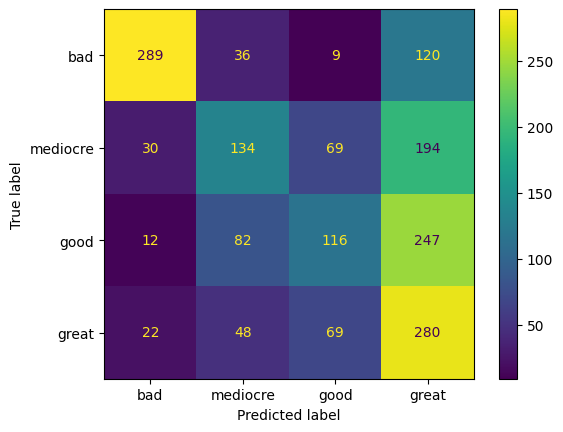

In [627]:
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy: ", accuracy)


print(sorted(Y_test.unique()))
print(Y_test.value_counts())


cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()


In [628]:
from sklearn.metrics import classification_report

# Assuming `y_test` is the true labels and `y_pred` is the predicted labels
print(classification_report(Y_test, Y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         bad       0.82      0.64      0.72       454
    mediocre       0.45      0.31      0.37       427
        good       0.44      0.25      0.32       457
       great       0.33      0.67      0.44       419

    accuracy                           0.47      1757
   macro avg       0.51      0.47      0.46      1757
weighted avg       0.51      0.47      0.46      1757



In [629]:
def calculate_c45_tree_complexity(tree, depth=0):
    if not isinstance(tree, dict):
        return 1, 1, depth  

    num_nodes = 1  
    num_leaves = 0
    max_depth = depth

    # Recursively count nodes and leaves for each child subtree
    feature = next(iter(tree))
    for value, subtree in tree[feature].items():
        subtree_nodes, subtree_leaves, subtree_depth = calculate_c45_tree_complexity(subtree, depth + 1)
        num_nodes += subtree_nodes
        num_leaves += subtree_leaves
        max_depth = max(max_depth, subtree_depth)

    return num_nodes, num_leaves, max_depth


num_nodes, num_leaves, max_depth = calculate_c45_tree_complexity(c45tree)

print(f"Number of nodes: {num_nodes}")
print(f"Number of leaves: {num_leaves}")
print(f"Maximum depth of the tree: {max_depth}")


Number of nodes: 5977
Number of leaves: 4518
Maximum depth of the tree: 28


In [630]:
def print_c45_tree(tree, depth=0):
    if not isinstance(tree, dict):
        print("  " * depth + f"--> {tree}")
        return

    feature = next(iter(tree))
    for value, subtree in tree[feature].items():
        print("  " * depth + f"[{feature} == {value}]")
        print_c45_tree(subtree, depth + 1)


print("C4.5 Decision Tree Structure:")
print_c45_tree(c45tree)


C4.5 Decision Tree Structure:
[vote_count == 0.0]
  --> 0
[vote_count == 1.0]
  [original_language_sv == 0.0]
    [original_language_da == 0.0]
      [original_language_uk == 0.0]
        [original_language_et == 0.0]
          [original_language_hu == 0.0]
            [original_language_nl == 0.0]
              [original_language_no == 0.0]
                [original_language_pl == 0.0]
                  [original_language_ko == 0.0]
                    [original_language_ja == 0.0]
                      [original_language_hi == 0.0]
                        [original_language_pt == 0.0]
                          [original_language_ru == 0.0]
                            [original_language_cn == 0.0]
                              [original_language_tr == 0.0]
                                [video == 0.0]
                                  [release_year == 0.0]
                                    [original_language_en == 0.0]
                                      --> 3
                   

In [632]:
from collections import Counter

#This function counts how often each feature is used as a splitting criterion in the tree to estimate its importance 
def get_feature_importance(tree, feature_counts=None):
    if feature_counts is None:
        feature_counts = Counter()

    if not isinstance(tree, dict):
        return feature_counts

    feature = next(iter(tree))
    feature_counts[feature] += 1

    for subtree in tree[feature].values():
        get_feature_importance(subtree, feature_counts)

    return feature_counts

feature_importance = get_feature_importance(c45tree)
print("Feature Importance (C4.5 Tree):")
for feature, count in feature_importance.most_common():
    print(f"{feature}: {count}")


Feature Importance (C4.5 Tree):
budget: 403
revenue: 220
popularity: 206
runtime: 177
release_day: 106
release_month: 92
release_year: 50
original_language_en: 32
original_language_fr: 17
original_language_es: 16
original_language_it: 12
original_language_pt: 10
original_language_de: 9
original_language_ko: 8
original_language_ja: 8
original_language_sv: 7
original_language_ru: 7
original_language_cn: 7
original_language_zh: 7
original_language_da: 6
original_language_hi: 6
original_language_nl: 5
original_language_pl: 5
original_language_fa: 5
original_language_hu: 4
original_language_no: 4
original_language_tr: 4
original_language_th: 4
original_language_et: 2
video: 2
original_language_el: 2
original_language_ar: 2
original_language_id: 2
original_language_sr: 2
vote_count: 1
original_language_uk: 1
original_language_cs: 1
original_language_bn: 1
original_language_fi: 1
original_language_sh: 1
original_language_bs: 1
original_language_ro: 1
original_language_te: 1
original_language_